# Monte Carlo Trade Simulation

In [11]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby

I only included the original data in what I loaded, then I reduced it down to only the original trade results.  Here are the first few rows so you can see what I used.

In [12]:
# Load the Trade Data
file_path = "C:/Users/earne/OneDrive/Upwork/trade_monte_carlo/data/" # Enter your file path here
file_name = "trade_data.csv" #enter name of csv file
trade_results = pd.read_csv(file_path + file_name)
trade_results.head(5)

,trade,cum_return,capital,%_drawdown_from_max,losses
0,-1.00,-1.00,"99,000.00",-0.01,1.00
1,3.41,2.41,"102,375.90",0.00,NaN
2,-1.00,1.41,"101,352.14",-0.01,1.00
3,4.85,6.26,"106,267.72",0.00,NaN
4,-1.00,5.26,"105,205.04",-0.01,1.00


Number of rows and columns

In [13]:
trade_results.shape

(156, 5)

For what you've asked, all you need is the "trade" column.  For future simulations, you can load the file and change the word 'trade' to match the column you want to simulate.

In [14]:
# Only use the trade results column:
trade_results = trade_results['trade'] #change this for the column name you want to model
trade_results.head(5) #this will show you the first 5 rows

0   -1.00
1    3.41
2   -1.00
3    4.85
4   -1.00
Name: trade, dtype: float64

Here I used 1000 random trades sampled from the original 156, then repeated that simulation 1000 times.  You can change the number of trades and number of simulations to see different scenarios.

In [15]:
# Parameters for the simulation
num_simulations = 1000
num_trades_per_simulation = 156
initial_capital = 100000

# Function to handle zero and negative values in cumulative return calculation
# Function to calculate drawdowns and consecutive losses

def calculate_drawdowns(trades):
    cumulative_returns = np.cumprod(1 + trades / 100)  # Convert percentage to decimal
    peak = np.maximum.accumulate(cumulative_returns)
    drawdowns = np.where(peak != 0, (cumulative_returns - peak) / peak, 0)
    max_drawdown = np.min(drawdowns)

    # Calculate consecutive losses
    losses = (trades < 0).astype(int)  # 1 if loss, 0 otherwise
    max_consecutive_losses = max([sum(1 for _ in group) for key, group in groupby(losses) if key == 1], default=0)
    
    return max_drawdown, np.mean(drawdowns), max_consecutive_losses


In [16]:
#Run the Monte Carlo Simulation
max_drawdowns = []
average_drawdowns = []
consecutive_losses = []
returns_dollars = []
simulation_results = []


for _ in range(num_simulations):
    sampled_trades = np.random.choice(trade_results, num_trades_per_simulation, replace=True)
    max_dd, avg_dd, max_loss_streak = calculate_drawdowns(sampled_trades)
    max_drawdowns.append(max_dd)
    average_drawdowns.append(avg_dd)
    consecutive_losses.append(max_loss_streak)
    cumulative_returns = [initial_capital]
    capital = initial_capital
    
     # Calculate total return starting from initial capital
    for trade in sampled_trades:
        capital *= (1 + trade / 100)  # Convert percent return to decimal and apply to capital
        cumulative_returns.append(capital)
    
    # Calculate returns for this simulation
    total_return = (capital - initial_capital) / initial_capital # Total return in percentage
    returns_dollars.append(total_return * initial_capital)
    simulation_results.append(cumulative_returns)

Distributions of results

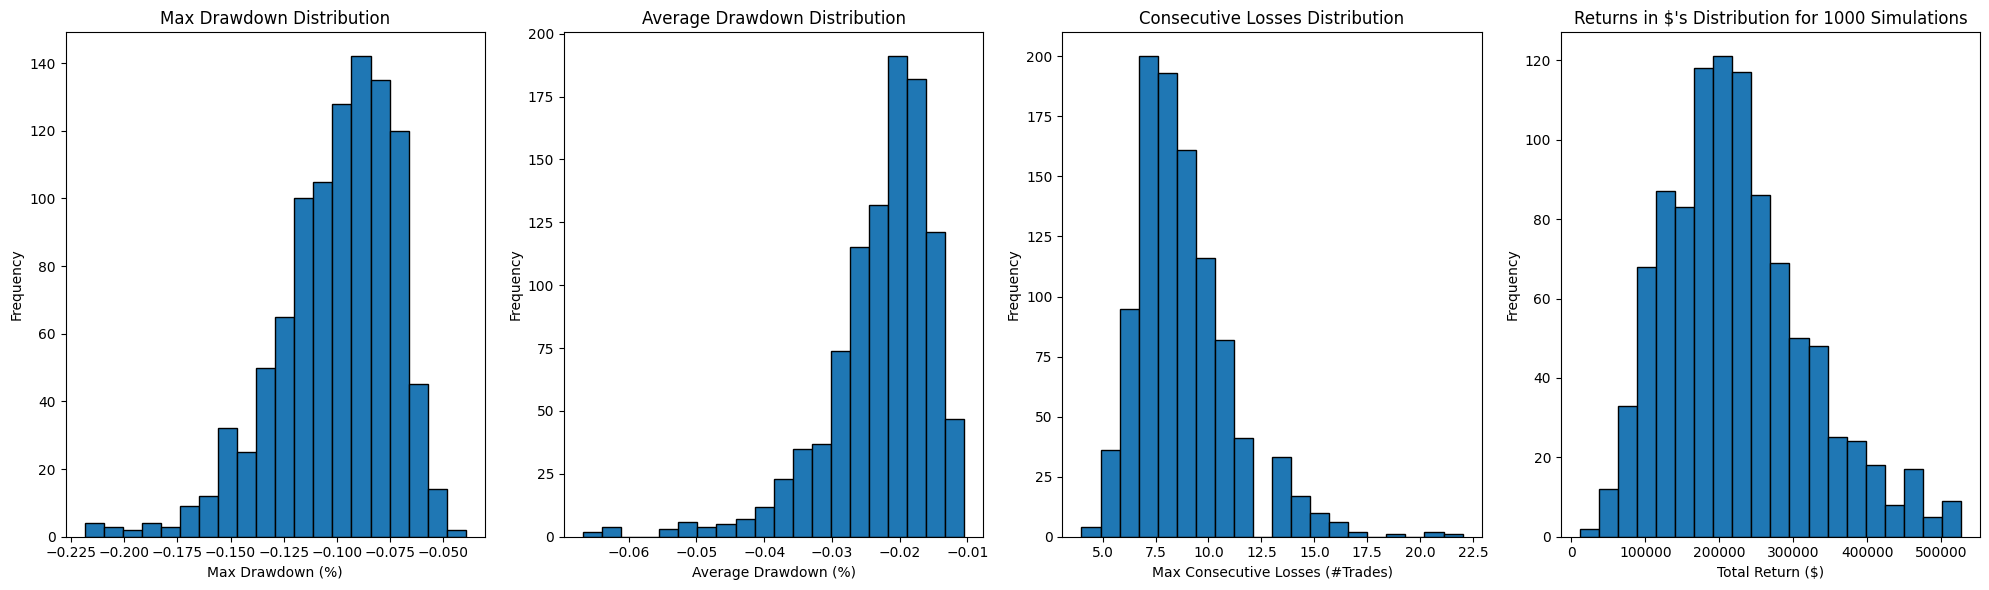

In [17]:
# Plot histogram of results
plt.figure(figsize=(20, 6))

# Max Drawdown
plt.subplot(1, 4, 1)
plt.hist(max_drawdowns, bins=20, edgecolor='black')
plt.title("Max Drawdown Distribution")
plt.xlabel("Max Drawdown (%)")
plt.ylabel("Frequency")

# Average Drawdown
plt.subplot(1, 4, 2)
plt.hist(average_drawdowns, bins=20, edgecolor='black')
plt.title("Average Drawdown Distribution")
plt.xlabel("Average Drawdown (%)")
plt.ylabel("Frequency")

# Consecutive Losses
plt.subplot(1, 4, 3)
plt.hist(consecutive_losses, bins=20, edgecolor='black')
plt.title("Consecutive Losses Distribution")
plt.xlabel("Max Consecutive Losses (#Trades)")
plt.ylabel("Frequency")

# Total returns ditribution in dollars for each of the trade simulations
plt.subplot(1, 4, 4)
plt.hist(returns_dollars, bins=20, edgecolor='black')
plt.title(f"Returns in $'s Distribution for {num_simulations} Simulations")
plt.xlabel("Total Return ($)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Plot the equity curves.  Each line represents the curve for the specified number of trades.  The number of lines reflects the number of simulations.

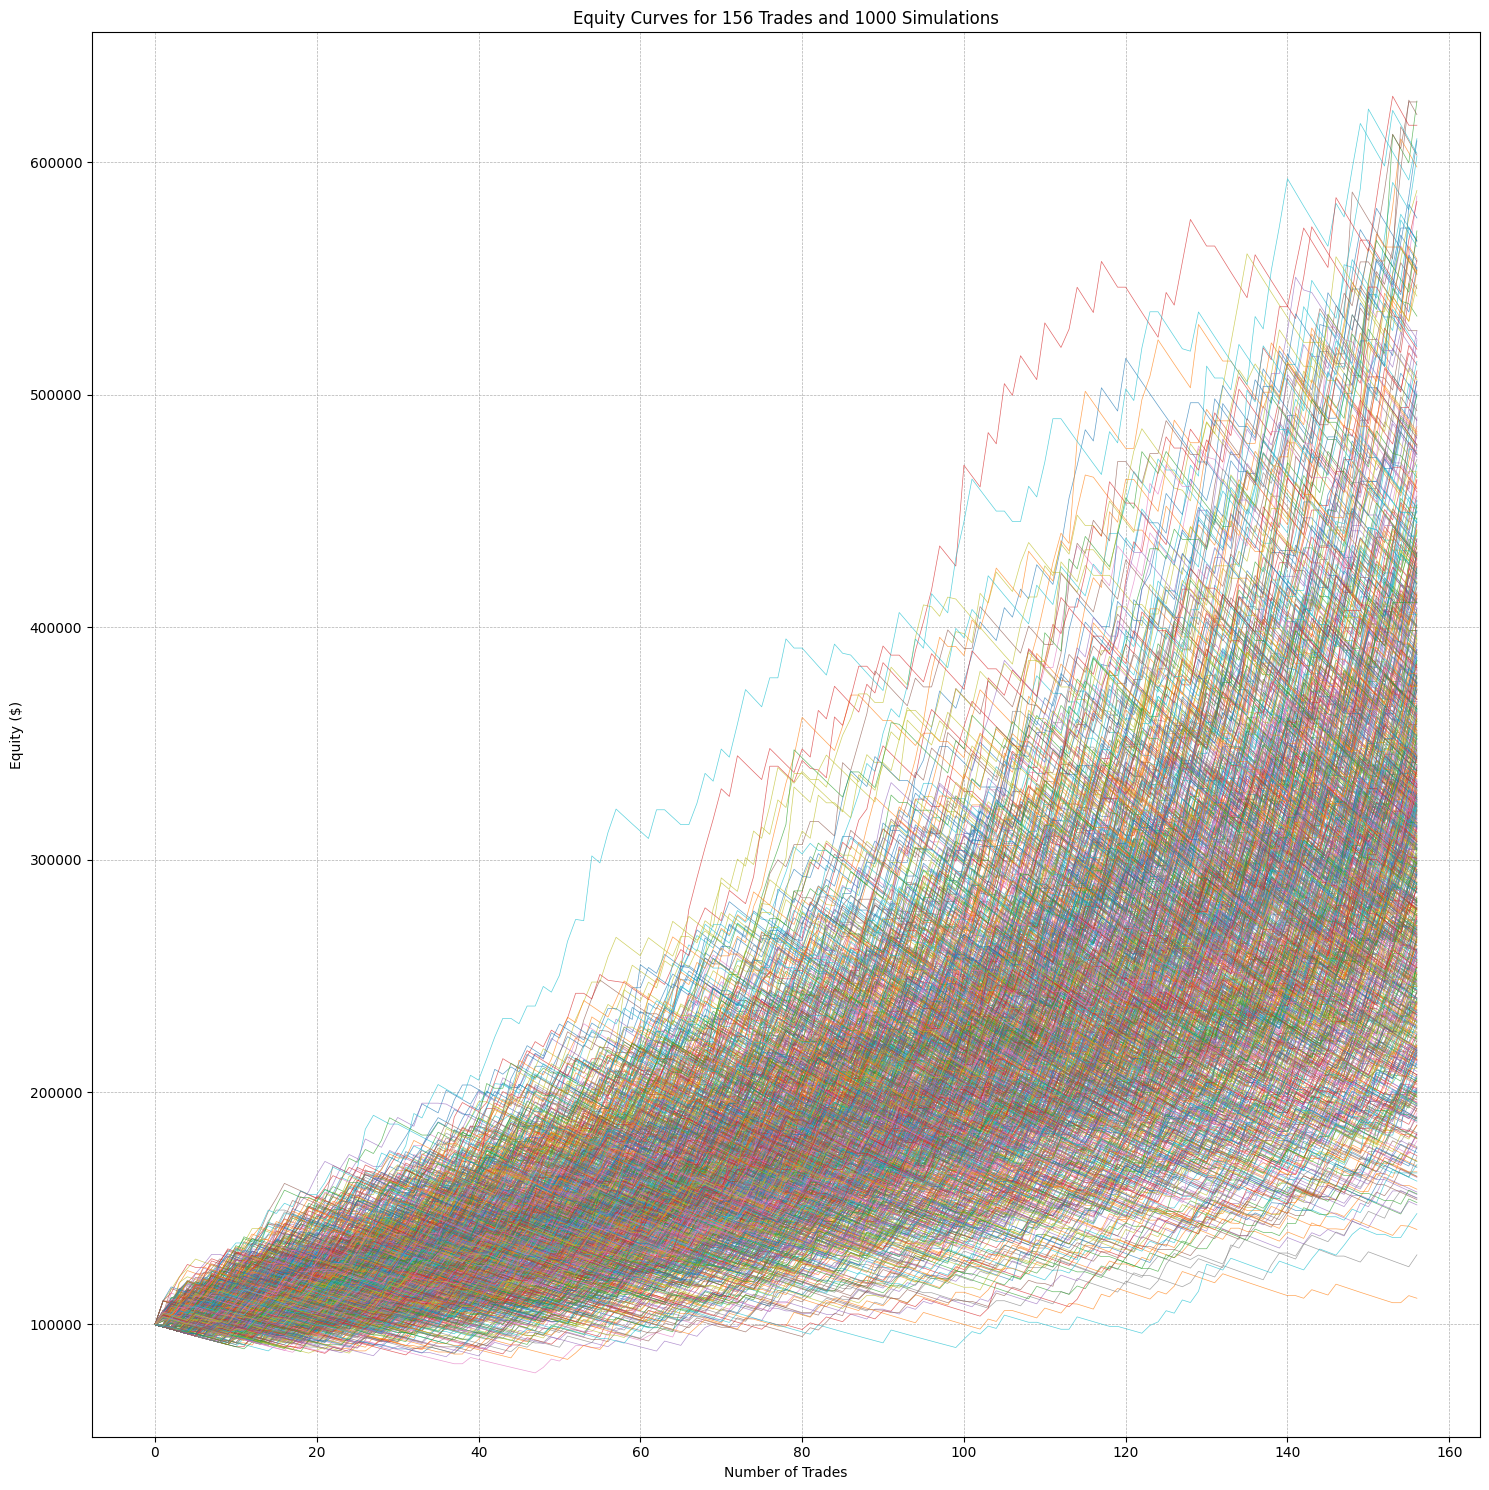

In [18]:
# Plot the cumulative returns for each simulation
plt.figure(figsize=(15, 15))

for simulation in simulation_results:
    plt.plot(simulation, linewidth=0.5, alpha=0.7)

plt.title(f'Equity Curves for {num_trades_per_simulation} Trades and {num_simulations} Simulations')
plt.xlabel('Number of Trades')
plt.ylabel('Equity ($)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

Here are the requested summary statistics.  Since we are simulating 1000 trades instead of 156, the strategy results in higher returns over time (or more trades).

In [19]:
# Set global formatting option for pandas
pd.options.display.float_format = '{:,.2f}'.format

months = num_trades_per_simulation / 7.8

# Simplified code for creating the summary statistics DataFrame
returns_dollars_mean = np.mean(returns_dollars)
returns_dollars_sd = np.std(returns_dollars)
returns_dollars_max = np.max(returns_dollars)
returns_dollars_min = np.min(returns_dollars)

gain_percent = [((value) / initial_capital) * 100 for value in 
                [returns_dollars_mean, returns_dollars_max, returns_dollars_min]]
gain_percent_sd = (returns_dollars_sd / initial_capital) * 100  # SD for gain percent

ret_per_month = [gain / months for gain in gain_percent]
ret_per_month_sd = gain_percent_sd / months  # SD for monthly return

ret_dd_ratio = [gain / (dd * 100) * -1 for gain, dd in zip(gain_percent, [np.mean(max_drawdowns), np.max(max_drawdowns), np.min(max_drawdowns)])]

# Create the DataFrame with rows in the correct order
summary_stats_df = pd.DataFrame({
    'Total return': [returns_dollars_mean, np.nan, returns_dollars_max, returns_dollars_min],
    'Gain (%)': [gain_percent[0], gain_percent_sd, gain_percent[1], gain_percent[2]],
    'Ret. per month (%)': [ret_per_month[0], ret_per_month_sd, ret_per_month[1], ret_per_month[2]],
    'Max DD (%)': [np.mean(max_drawdowns) * 100, np.std(max_drawdowns), np.max(max_drawdowns) * 100, np.min(max_drawdowns) * 100],
    'Average dd (%)': [np.mean(average_drawdowns) * 100, np.std(average_drawdowns), np.max(average_drawdowns) * 100, np.min(average_drawdowns) * 100],
    'Consec_loss': [np.mean(consecutive_losses), np.nan, np.min(consecutive_losses), np.max(consecutive_losses)],
    'Ret.//dd.': [ret_dd_ratio[0], np.nan, ret_dd_ratio[1], ret_dd_ratio[2]]
}, index=['Average', 'SD', 'Best', 'Worst'])

summary_stats_df = summary_stats_df.fillna('')

# Display the DataFrame
summary_stats_df


,Total return,Gain (%),Ret. per month (%),Max DD (%),Average dd (%),Consec_loss,Ret.//dd.
Average,"222,958.73",222.96,11.15,-9.92,-2.29,8.74,22.48
SD,,94.77,4.74,0.03,0.01,,
Best,"526,373.41",526.37,26.32,-3.94,-1.05,4.00,133.58
Worst,"11,293.78",11.29,0.56,-21.85,-6.67,22.00,0.52


Adding the median return for context

In [20]:
median_return = {'Median Return' : np.median(returns_dollars)}

median_return

{'Median Return': 213266.29331729846}